##### Copyright 2020 The TensorFlow Authors.

In [3]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Setup

Import necessary modules and dependencies. You'll be using `tf.keras.utils.audio_dataset_from_directory` (introduced in TensorFlow 2.10), which helps generate audio classification datasets from directories of `.wav` files. You'll also need [seaborn](https://seaborn.pydata.org) for visualization in this tutorial.

In [4]:
!pip install -U -q tensorflow==2.16.1  tensorflow_datasets

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [5]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Import the Speech Commands dataset

This is the [dataset](https://dax-cdn.cdn.appdomain.cloud/dax-tensorflow-speech-commands/1.0.1/data_preview/index.html) that you will be working on. This dataset consists of 65,000 WAV Files and the audio clips were originally collected by Google, and recorded by volunteers in uncontrolled locations around the world.

In [6]:
DATASET_PATH = '/kaggle/input/tvd-2024-reconocimiento-de-comandos-de-voz/train/train/audio'

data_dir = pathlib.Path(DATASET_PATH)

The dataset's audio clips are stored in 31 folders corresponding to each speech command. 

- 20 core words: `yes`, `no`, `up`, `down`, `left`,`right`, `on`, `off`, `stop`, `go`, `zero`, `one`,`two`, `three`, `four`, `five`,`six`, `seven`, `eight`, `nine`,   

- 10 auxiliary words: `bed`, `bird`, `cat`, `dog`, `happy`, `house`, `marvin`, `sheila`, `tree` and `wow`
  
- And background noise: `doing_the_dishes`, `dude_miaowing`, `exercise_bike`, `pink_noise`, `running_tap`, and `white_noise`.

In [7]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['no' 'two' 'four' 'five' 'nine' 'right' '_background_noise_' 'off' 'yes'
 'six' 'dog' 'left' 'bird' 'wow' 'zero' 'eight' 'bed' 'go' 'house' 'tree'
 'seven' 'on' 'three' 'one' 'down' 'stop' 'up' 'happy' 'marvin' 'cat'
 'sheila']


Divided into directories this way, you can easily load the data using `keras.utils.audio_dataset_from_directory`.

The audio clips are 1 second or less at 16kHz. The `output_sequence_length=16000` pads the short ones to exactly 1 second (and would trim longer ones) so that they can be easily batched.

In [8]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 64727 files belonging to 31 classes.
Using 51782 files for training.
Using 12945 files for validation.

label names: ['_background_noise_' 'bed' 'bird' 'cat' 'dog' 'down' 'eight' 'five'
 'four' 'go' 'happy' 'house' 'left' 'marvin' 'nine' 'no' 'off' 'on' 'one'
 'right' 'seven' 'sheila' 'six' 'stop' 'three' 'tree' 'two' 'up' 'wow'
 'yes' 'zero']


The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of `(batch, samples, channels)`.

In [9]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

This dataset only contains single channel audio, so use the `tf.squeeze` function to drop the extra axis:

In [10]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

The `utils.audio_dataset_from_directory` function only returns up to two splits. It's a good idea to keep a test set separate from your validation set.
Ideally you'd keep it in a separate directory, but in this case you can use `Dataset.shard` to split the validation set into two halves. Note that iterating over **any** shard will load **all** the data, and only keep its fraction.

In [11]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [12]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


Let's plot a few audio waveforms:

In [13]:
label_names[[1,1,3,0]]

array(['bed', 'bed', 'cat', '_background_noise_'], dtype='<U18')

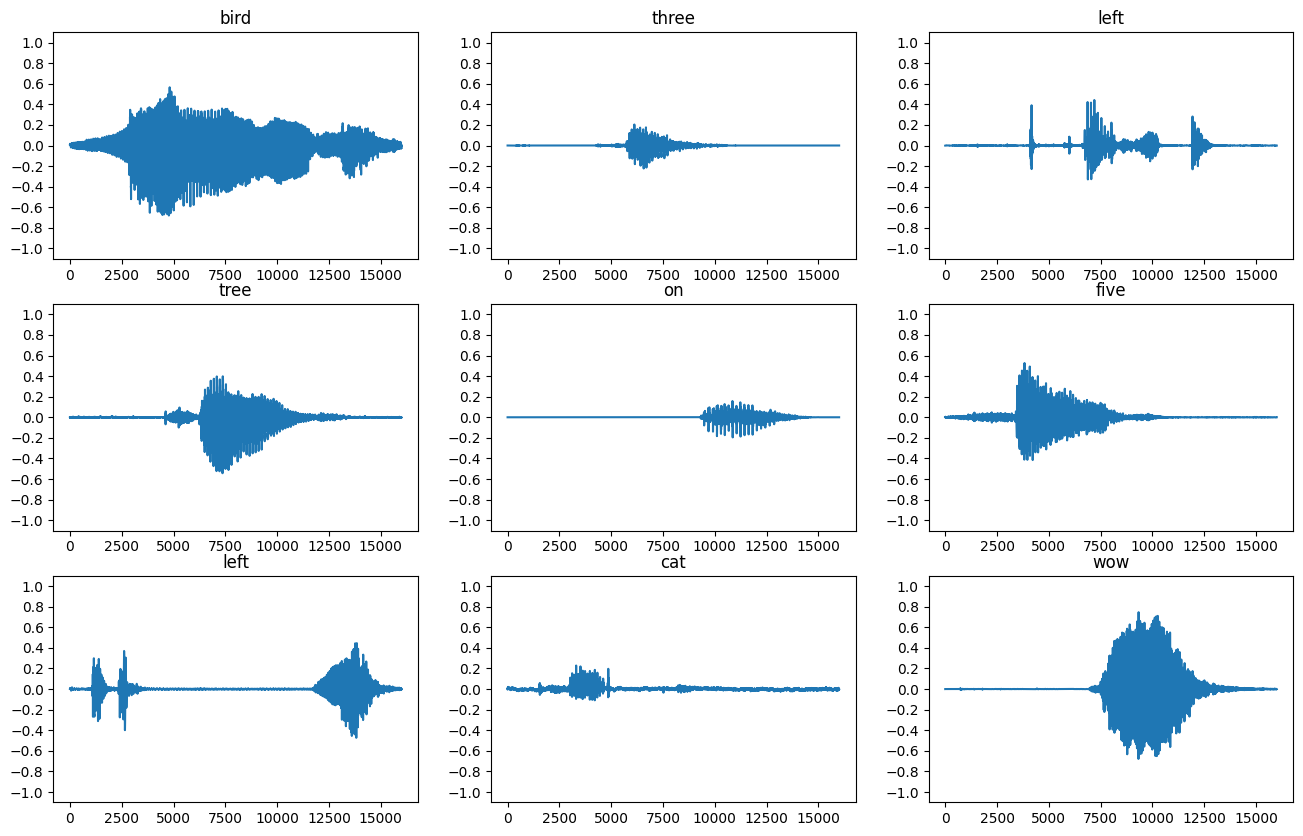

In [14]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

## Convert waveforms to spectrograms

The waveforms in the dataset are represented in the time domain. Next, you'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the [short-time Fourier transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) to convert the waveforms to as [spectrograms](https://en.wikipedia.org/wiki/Spectrogram), which show frequency changes over time and can be represented as 2D images. You will feed the spectrogram images into your neural network to train the model.

A Fourier transform (`tf.signal.fft`) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

Create a utility function for converting waveforms to spectrograms:

- The waveforms need to be of the same length, so that when you convert them to spectrograms, the results have similar dimensions. This can be done by simply zero-padding the audio clips that are shorter than one second (using `tf.zeros`).
- When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on the STFT parameters choice, refer to [this Coursera video](https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe) on audio signal processing and STFT.
- The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial you'll only use the magnitude, which you can derive by applying `tf.abs` on the output of `tf.signal.stft`.

In [15]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram


def get_mel_spectrogram(waveform, num_mel_bins=128):
    # Compute the STFT.
    spectrogram = tf.signal.stft(
        waveform, frame_length=255, frame_step=128
    )
    spectrogram = tf.abs(spectrogram)

    num_spectrogram_bins = spectrogram.shape[-1]

    
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=num_mel_bins,
        num_spectrogram_bins=num_spectrogram_bins,
        sample_rate=16000,
        lower_edge_hertz=80.0, 
        upper_edge_hertz=8000.0)

    mel_spectrogram = tf.matmul(spectrogram, linear_to_mel_weight_matrix)
    mel_spectrogram = tf.math.log1p(mel_spectrogram)

    mel_spectrogram = mel_spectrogram[..., tf.newaxis]
    
    return mel_spectrogram

def get_mfcc(waveform, num_mel_bins=128, num_mfccs=13):
    log_mel_spectrogram = get_mel_spectrogram(waveform, num_mel_bins)
    
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(tf.squeeze(log_mel_spectrogram, axis=-1))

    mfccs = mfccs[..., :num_mfccs]  # Select the desired number of MFCCs
    mfccs = mfccs[..., tf.newaxis]
    return mfccs

def get_power_spectrogram(waveform):
    # Compute the STFT
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    # Compute the power spectrogram (squared magnitude)
    power_spectrogram = tf.square(tf.abs(spectrogram))
    power_spectrogram = power_spectrogram[..., tf.newaxis]
    return power_spectrogram



Next, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

In [16]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: bird
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: three
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Now, define a function for displaying a spectrogram:

In [17]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

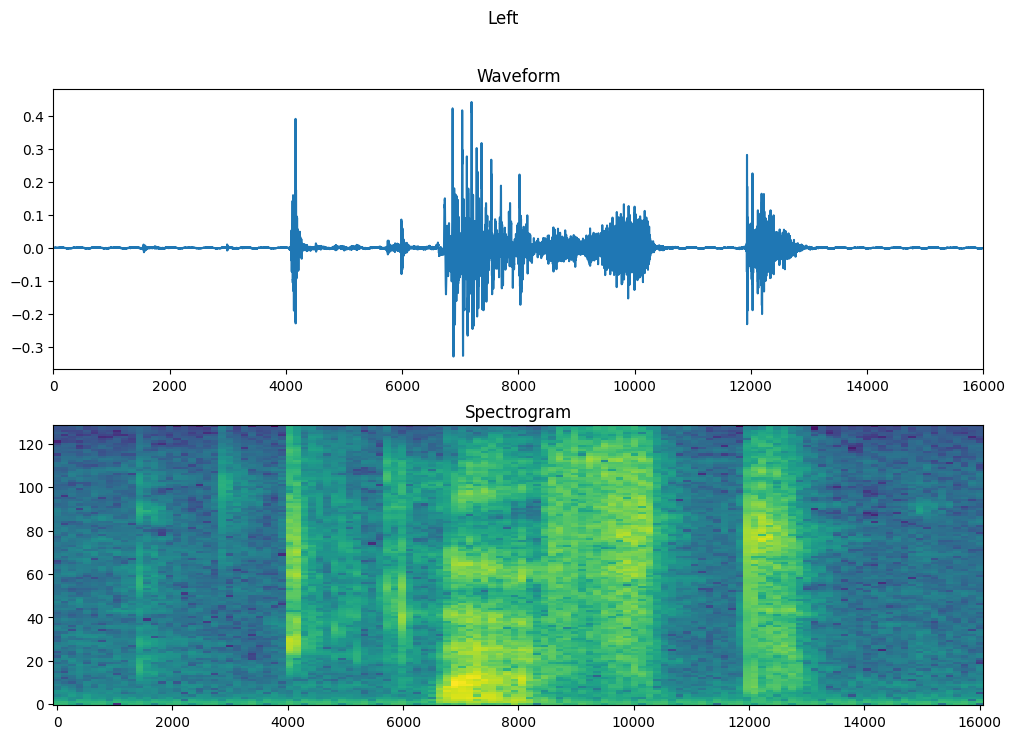

In [18]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Now, create spectrogram datasets from the audio datasets:

In [19]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)


def make_mel_ds(ds, bins=128):
  return ds.map(
      map_func=lambda audio,label: (get_mel_spectrogram(audio, bins), label),
      num_parallel_calls=tf.data.AUTOTUNE)

def make_mfcc_ds(ds, bins=128, mfcss=13):
  return ds.map(
      map_func=lambda audio,label: (get_mfcc(audio, bins, mfcss), label),
      num_parallel_calls=tf.data.AUTOTUNE)

def make_power_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_power_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

    

In [20]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Examine the spectrograms for different examples of the dataset:

In [21]:
spectrogram_datasets = {
    'spectrogram': {
        'train': make_spec_ds(train_ds),
        'val': make_spec_ds(val_ds),
        'test': make_spec_ds(test_ds)
    },
    'power_spectrogram': {
        'train': make_power_ds(train_ds),
        'val': make_power_ds(val_ds),
        'test': make_power_ds(test_ds)
    },
    'mel_spectrogram_32': {
        'train': make_mel_ds(train_ds, bins=32),
        'val': make_mel_ds(val_ds, bins=32),
        'test': make_mel_ds(test_ds, bins=32)
    },
    'mel_spectrogram_64': {
        'train': make_mel_ds(train_ds, bins=64),
        'val': make_mel_ds(val_ds, bins=64),
        'test': make_mel_ds(test_ds, bins=64)
    },
    'mel_spectrogram_128': {
        'train': make_mel_ds(train_ds, bins=128),
        'val': make_mel_ds(val_ds, bins=128),
        'test': make_mel_ds(test_ds, bins=128)
    },
    'mfcc_13': {
        'train': make_mfcc_ds(train_ds, mfcss=13),
        'val': make_mfcc_ds(val_ds, mfcss=13),
        'test': make_mfcc_ds(test_ds, mfcss=13)
    },
    'mfcc_64_13': {
        'train': make_mfcc_ds(train_ds, bins=64, mfcss=13),
        'val': make_mfcc_ds(val_ds, bins=64, mfcss=13),
        'test': make_mfcc_ds(test_ds, bins=64, mfcss=13)
    },
    'mfcc_40': {
        'train': make_mfcc_ds(train_ds, mfcss=40),
        'val': make_mfcc_ds(val_ds, mfcss=40),
        'test': make_mfcc_ds(test_ds, mfcss=40)
    },
    'mfcc_64': {
        'train': make_mfcc_ds(train_ds, mfcss=64),
        'val': make_mfcc_ds(val_ds, mfcss=64),
        'test': make_mfcc_ds(test_ds, mfcss=64)
    },
    'mfcc_64_64': {
        'train': make_mfcc_ds(train_ds, bins=64, mfcss=64),
        'val': make_mfcc_ds(val_ds, bins=64, mfcss=64),
        'test': make_mfcc_ds(test_ds, bins=64, mfcss=64)
    }
}

## Build and train the model

In [22]:
ds_dict = spectrogram_datasets['mel_spectrogram_64']
train_spectrogram_ds  = ds_dict['train'].cache().shuffle(85000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = ds_dict['val'].cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = ds_dict['test'].cache().prefetch(tf.data.AUTOTUNE)


In [23]:
from tensorflow.keras import layers, Sequential, regularizers
from tensorflow.keras.models import Sequential, Model

In [24]:
example_spectrograms = next(iter(train_spectrogram_ds))[0]  # Get a batch and take the first element
input_shape = example_spectrograms.shape[1:]  # Remove batch dimension
print('Input shape:', input_shape)
num_labels = len(label_names)


Input shape: (124, 64, 1)


In [25]:
# Assuming spectrogram_datasets is defined and loaded as in your original code

ds_dict = spectrogram_datasets['mel_spectrogram_64']
train_spectrogram_ds = ds_dict['train'].cache().shuffle(85000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = ds_dict['val'].cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = ds_dict['test'].cache().prefetch(tf.data.AUTOTUNE)


In [26]:
example_spectrograms = next(iter(train_spectrogram_ds))[0]  # Get a batch and take the first element
input_shape = example_spectrograms.shape[1:]  # Remove batch dimension
print('Input shape:', input_shape)
num_labels = len(label_names)


Input shape: (124, 64, 1)


In [27]:

import numpy as np

class SpecAugment2(layers.Layer):
    def __init__(self, freq_mask_param=5, time_mask_param=10,
                 n_freq_mask=5, n_time_mask=3, mask_value=None, **kwargs):
        """
        SpecAugment Layer Implementation

        Args:
            freq_mask_param (int): Maximum size of the frequency mask.
            time_mask_param (int): Maximum size of the time mask.
            n_freq_mask (int): Number of frequency masks to apply.
            n_time_mask (int): Number of time masks to apply.
            mask_value (float): Value to use for the masked elements. If None, the mean of each spectrogram will be used.
        """
        super(SpecAugment2, self).__init__(**kwargs)
        self.freq_mask_param = freq_mask_param
        self.time_mask_param = time_mask_param
        self.n_freq_mask = n_freq_mask
        self.n_time_mask = n_time_mask
        self.mask_value = mask_value

    def call(self, inputs, training=None):
        if training:
            input_shape = tf.shape(inputs)
            batch_size, time_steps, freq_bins, n_channels = input_shape[0], input_shape[1], input_shape[2], input_shape[3]

            # Ensure inputs are 4D: (batch_size, time_steps, freq_bins, n_channels)
            if len(inputs.shape) != 4:
                raise ValueError("Inputs must be a 4D tensor (batch_size, time_steps, freq_bins, n_channels)")

            augmented_inputs = inputs

            for _ in range(self.n_freq_mask):
                # Generate a random frequency mask size
                f = tf.random.uniform(shape=[], minval=0, maxval=self.freq_mask_param, dtype=tf.int32)
                f0 = tf.random.uniform(shape=[], minval=0, maxval=freq_bins - f, dtype=tf.int32)
    
                # Create a condition tensor for masking
                freq_condition = tf.logical_and(
                    tf.range(freq_bins) >= f0,
                    tf.range(freq_bins) < f0 + f
                )
    
                # Reshape the condition to be broadcastable to the input shape
                freq_condition = tf.reshape(freq_condition, (1, 1, freq_bins, 1))
    
                # Determine mask value
                current_mask_value = self.mask_value if self.mask_value is not None else tf.reduce_mean(inputs)
    
                # Apply the mask using tf.where
                augmented_inputs = tf.where(freq_condition, tf.cast(current_mask_value, tf.float32), augmented_inputs)

            # 2. Time Masking
            for _ in range(self.n_time_mask):
                # Generate a random time mask size
                t = tf.random.uniform(shape=[], minval=0, maxval=self.time_mask_param, dtype=tf.int32)
                t0 = tf.random.uniform(shape=[], minval=0, maxval=time_steps - t, dtype=tf.int32)
    
                # Create a condition tensor for masking
                time_condition = tf.logical_and(
                    tf.range(time_steps) >= t0,
                    tf.range(time_steps) < t0 + t
                )
    
                # Reshape the condition to be broadcastable to the input shape
                time_condition = tf.reshape(time_condition, (1, time_steps, 1, 1))
    
                # Determine mask value (mean or specified value)
                current_mask_value = self.mask_value if self.mask_value is not None else tf.reduce_mean(inputs)
    
                # Apply the mask using tf.where
                augmented_inputs = tf.where(time_condition, tf.cast(current_mask_value, tf.float32), augmented_inputs)
    
            return augmented_inputs
        else:
            return inputs

    def get_config(self):
        config = super(SpecAugment, self).get_config()
        config.update({
            'freq_mask_param': self.freq_mask_param,
            'time_mask_param': self.time_mask_param,
            'n_freq_mask': self.n_freq_mask,
            'n_time_mask': self.n_time_mask,
            'mask_value': self.mask_value
        })
        return config

In [31]:

# Get the input shape and number of labels from the dataset
for spectrogram, _ in train_spectrogram_ds.take(1):
    input_shape = spectrogram.shape[1:]
num_labels = len(commands)


# Normalization Layer
norm_layer = layers.Normalization()
norm_layer.adapt(train_spectrogram_ds.map(lambda x, _: x))

# Residual Block with Batch Normalization
def residual_block(x, filters, kernel_size=3, stride=1):
    """A residual block with Batch Normalization."""
    shortcut = x

    # First convolution layer
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Second convolution layer
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Add shortcut (adjust shortcut if dimensions change)
    if shortcut.shape[-1] != filters or stride != 1:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = layers.LayerNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

# Enhanced Model Definition
def create_model(input_shape, num_labels, norm_layer):
    spec_augment = SpecAugment2(freq_mask_param=15,
                           time_mask_param=20,
                           n_freq_mask=2,
                           n_time_mask=2,
                           mask_value=0)
    
    inputs = layers.Input(shape=input_shape)

    x = spec_augment(inputs)
    
    x = norm_layer(x)
    x = layers.Resizing(64,64)(x)

    # Initial Convolution
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Residual Blocks
    x = residual_block(x,64)
    x = layers.MaxPooling2D()(x)
    x = residual_block(x, 128)
    x = layers.MaxPooling2D()(x)
    x = residual_block(x, 128)
    x = layers.MaxPooling2D()(x)
    x = residual_block(x, 256)

    # Global Average Pooling and Output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_labels)(x)

    return Model(inputs, outputs)

# Create and Compile the Model
model = create_model(input_shape, num_labels, norm_layer)
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 124, 64,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spec_augment2_1     │ (None, 124, 64,   │          0 │ input_layer_1[0]… │
│ (SpecAugment2)      │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 124, 64,   │          3 │ spec_augment2_1[… │
│ (Normalization)     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing_1          │ (None, 64, 64, 1) │          0 │ normalization_1[… │
│ (Resizing)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │        640 │ resizing_1[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_7 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 64, 64,    │     36,928 │ re_lu_7[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_8 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 64, 64,    │     36,928 │ re_lu_8[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ re_lu_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_9 (ReLU)      │ (None, 64, 64,    │          0 │ add_3[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ re_lu_9[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_12[0][0] 

 Total params: 1,597,090 (6.09 MB)

 Trainable params: 1,594,655 (6.08 MB)

 Non-trainable params: 2,435 (9.52 KB)

In [32]:
import tensorflow as tf
final_learning_rate = 0.0000001
initial_learning_rate = 0.001

# Compile the model with ReduceLROnPlateau learning rate schedule
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate, gradient_accumulation_steps=2),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

# Set up the ReduceLROnPlateau callback
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',  # You can also monitor 'val_accuracy' or other metrics
    factor=0.1,  # Reduce the learning rate by this factor
    patience=8,  # Number of epochs with no improvement before reducing LR
    min_lr=final_learning_rate,  # Minimum learning rate
    verbose=1  # To print when the learning rate is reduced
)

# Train the model
EPOCHS = 50  # Adjust as necessary
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=[tf.keras.callbacks.EarlyStopping(verbose=1, patience=20), lr_scheduler],
)


Epoch 1/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 57s 49ms/step - accuracy: 0.4031 - loss: 2.1054 - val_accuracy: 0.6258 - val_loss: 1.2644 - learning_rate: 0.0010
Epoch 2/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step - accuracy: 0.8975 - loss: 0.3515 - val_accuracy: 0.8728 - val_loss: 0.4207 - learning_rate: 0.0010
Epoch 3/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step - accuracy: 0.9304 - loss: 0.2380 - val_accuracy: 0.8908 - val_loss: 0.3745 - learning_rate: 0.0010
Epoch 4/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step - accuracy: 0.9433 - loss: 0.1879 - val_accuracy: 0.9109 - val_loss: 0.3090 - learning_rate: 0.0010
Epoch 5/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step - accuracy: 0.9510 - loss: 0.1642 - val_accuracy: 0.9251 - val_loss: 0.2500 - learning_rate: 0.0010
Epoch 6/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step - accuracy: 0.9546 - loss: 0.1512 - val_accuracy: 0.9384 - val_loss: 0.2154 - learning_rate: 0.0010
Epoch 7/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step - accuracy: 0.9620 - l

In [134]:
EPOCHS = 50  # Adjust as necessary
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=[tf.keras.callbacks.EarlyStopping(verbose=1, patience=20), lr_scheduler],
)

Epoch 1/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.9479 - loss: 0.1656 - val_accuracy: 0.9658 - val_loss: 0.1347 - learning_rate: 1.0000e-04
Epoch 2/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.9519 - loss: 0.1569 - val_accuracy: 0.9657 - val_loss: 0.1378 - learning_rate: 1.0000e-04
Epoch 3/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.9478 - loss: 0.1692 - val_accuracy: 0.9660 - val_loss: 0.1357 - learning_rate: 1.0000e-04
Epoch 4/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.9503 - loss: 0.1606 - val_accuracy: 0.9650 - val_loss: 0.1407 - learning_rate: 1.0000e-04
Epoch 5/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.9524 - loss: 0.1523 - val_accuracy: 0.9666 - val_loss: 0.1378 - learning_rate: 1.0000e-04
Epoch 6/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.9547 - loss: 0.1453 - val_accuracy: 0.9647 - val_loss: 0.1412 - learning_rate: 1.0000e-04
Epoch 7/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/ste

In [172]:
final_learning_rate = 0.0000001
initial_learning_rate = 0.001
decay_steps = 70000  # Adjust this according to your training steps or epochs

# Calculate decay rate using the exponential decay formula
decay_rate = (final_learning_rate / initial_learning_rate) ** (1 / decay_steps)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=False  # You can set this to True for step decay
)

# Compile the model with the new learning rate schedule
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

# Train the model
EPOCHS = 50  # Adjust as necessary
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=[tf.keras.callbacks.EarlyStopping(verbose=1, patience=20)],
)

Epoch 1/50
  9/810 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.0393 - loss: 7.8785 

I0000 00:00:1735574871.469052     101 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_9', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_8', 4 bytes spill stores, 12 bytes spill loads



629/810 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.1358 - loss: 4.7209

I0000 00:00:1735574892.157944     101 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_7', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads



810/810 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - accuracy: 0.1729 - loss: 4.3685 - val_accuracy: 0.7178 - val_loss: 1.2440
Epoch 2/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.6287 - loss: 1.5491 - val_accuracy: 0.8560 - val_loss: 0.7753
Epoch 3/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.7301 - loss: 1.2047 - val_accuracy: 0.8795 - val_loss: 0.7888
Epoch 4/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.7580 - loss: 1.0901 - val_accuracy: 0.9110 - val_loss: 0.6096
Epoch 5/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.7803 - loss: 0.9977 - val_accuracy: 0.9044 - val_loss: 0.5812
Epoch 6/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.8027 - loss: 0.9123 - val_accuracy: 0.8929 - val_loss: 0.6179
Epoch 7/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.8077 - loss: 0.9019 - val_accuracy: 0.9325 - val_loss: 0.4921
Epoch 8/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.8136 - loss: 0.8598 - val_accurac

In [184]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # Added learning rate
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [29]:



EPOCHS = 10 # Increased epochs
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=[tf.keras.callbacks.EarlyStopping(verbose=1, patience=10),tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',  # The metric to monitor
        factor=0.1,  # The factor by which the learning rate will be reduced
        patience=5,  # Number of epochs with no improvement after which learning rate will be reduced
        min_lr=1e-6,  # Minimum learning rate
        verbose=1  # Print a message when the learning rate is reduced
    )] # Increased patience
)


Epoch 1/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.9826 - loss: 0.1236 - val_accuracy: 0.9672 - val_loss: 0.1835 - learning_rate: 1.0000e-04
Epoch 2/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.9831 - loss: 0.1189 - val_accuracy: 0.9660 - val_loss: 0.1845 - learning_rate: 1.0000e-04
Epoch 3/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.9830 - loss: 0.1226 - val_accuracy: 0.9674 - val_loss: 0.1815 - learning_rate: 1.0000e-04
Epoch 4/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.9840 - loss: 0.1176 - val_accuracy: 0.9670 - val_loss: 0.1831 - learning_rate: 1.0000e-04
Epoch 5/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.9843 - loss: 0.1159 - val_accuracy: 0.9655 - val_loss: 0.1830 - learning_rate: 1.0000e-04
Epoch 6/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.9844 - loss: 0.1165 - val_accuracy: 0.9657 - val_loss: 0.1824 - learning_rate: 1.0000e-04
Epoch 7/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/ste

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [33]:
model.evaluate(test_spectrogram_ds, return_dict=True)

102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.9771 - loss: 0.1342


{'accuracy': 0.9760839343070984, 'loss': 0.12238286435604095}

### Display a confusion matrix

Use a [confusion matrix](https://developers.google.com/machine-learning/glossary#confusion-matrix) to check how well the model did classifying each of the commands in the test set:


In [197]:
y_pred = model.predict(test_spectrogram_ds)

102/102 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step


In [198]:
y_pred = tf.argmax(y_pred, axis=1)

In [199]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

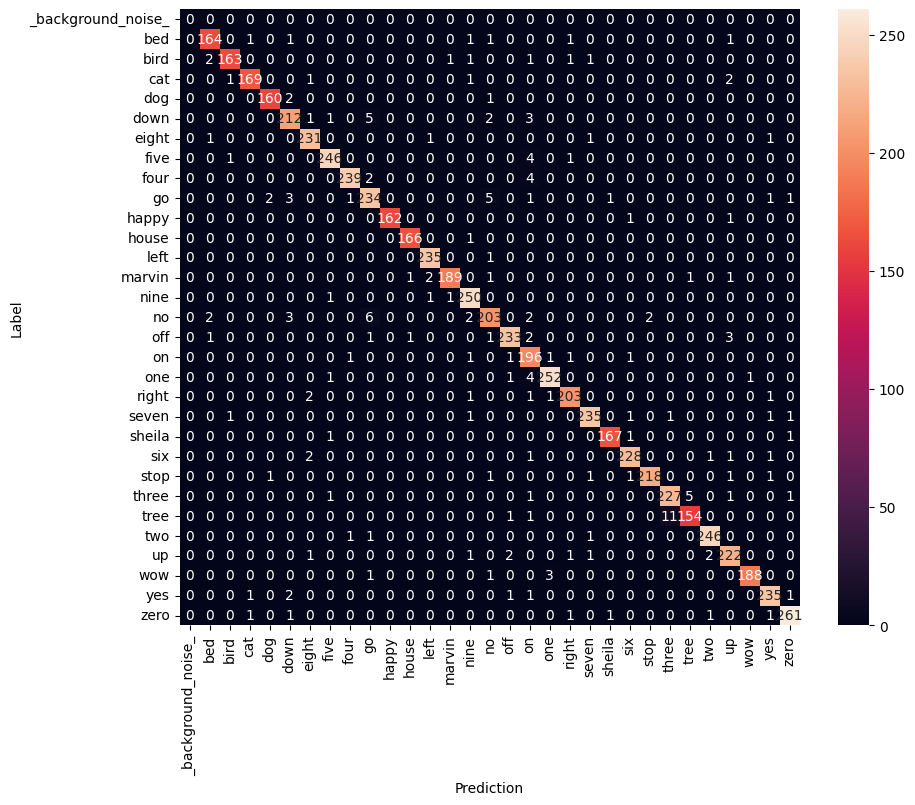

In [200]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Generate the submission file

The code below produces the `submission.csv` file, which you are required to submit for the competition. **Please do not make any changes in this cell**. 

In [202]:
import pandas as pd

l = [[i,j] for i,j in zip(list(range(1,len(y_pred)+1)), y_pred.numpy().tolist())]

df = pd.DataFrame(l, columns=['ID','labels'])

df.to_csv('submission.csv', index=False)